# Set-up

In [4]:
import os
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib import colors
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cmcrameri import cm

from treeconfigparser import TreeConfigParser

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import models.reg as rg
import models.seg as sg
from Data import Data_eval
from include.loss import pixel_weighted_cross_entropy, calculate_weighted_plume
from include import generators
import model_eval

import matplotlib_functions
matplotlib_functions.setMatplotlibParam()
plt.viridis()

import ddeq_cosmo.build_ds as build_ds
from ddeq_cosmo.ddeq_eval import get_mean_loss, shift_to_proba, get_all_loss
from scipy.optimize import differential_evolution

from omegaconf import DictConfig, OmegaConf
from cfg.convert_cfg_to_yaml import save_myyaml_from_mycfg

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"
dir_plots = "/cerea_raid/users/dumontj/dev/coco2/dl/eval/paper-seg"
dir_eval_ddeq = "/libre/dumontj/coco2/ddeq/eval"

<Figure size 1920x1440 with 0 Axes>

## DDEQ

In [6]:
def get_b2_pred(y_test, ddeq_pred_bool):
    res = differential_evolution(get_mean_loss, args=(y_test, ddeq_pred_bool), bounds = [[0,1], [0,1]])
    [proba_min, proba_max] = res["x"]
    loss_mean = res["fun"]

    shifted_b2_pred_test = shift_to_proba(ddeq_pred_bool,proba_max,proba_min)
    return shifted_b2_pred_test

In [7]:
def get_weighted_y_test(plume, min_w, max_w, curve="linear"):
    w_plume = calculate_weighted_plume(plume, min_w, max_w, curve)
    y_test = tf.convert_to_tensor(w_plume, np.float32) 
    return y_test

In [8]:
def get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test):
    all_b1_wbce = model_eval.get_b1_seg_wbce(y_test)
    shifted_b2_pred = get_b2_pred(y_test, ddeq_pred_bool)
    all_ddeq_wbce = model_eval.get_wbce(y_test, shifted_b2_pred)
    all_ddeq_nwbce = all_ddeq_wbce / all_b1_wbce
    return all_ddeq_nwbce

In [10]:
PS = "Berlin"
ds_ber = xr.open_dataset(os.path.join(dir_eval_ddeq, 
                                  build_ds.get_abbrev_source(PS),
                                  "res_ddeq.nc"))

In [11]:
ddeq_pred_bool = tf.convert_to_tensor(np.expand_dims(ds_ber.ddeq_plumes.values, -1), np.float32) 

In [11]:
y_test_01 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=0.1)
y_test_1 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=1)
y_test_2 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=2)
y_test_4 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=4)
y_test_6 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=6)
y_test_8 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=8)
y_test_10 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=8)
y_test_20 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=20)
y_test_50 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=50)
y_test_4_exp = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=4, curve="exponential")

In [13]:
all_nwbce_ddeq_01 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_01)
all_nwbce_ddeq_1 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_1)
all_nwbce_ddeq_2 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_2)
all_nwbce_ddeq_4 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_4)
all_nwbce_ddeq_6 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_6)
all_nwbce_ddeq_10 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_10)
all_nwbce_ddeq_20 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_20)
all_nwbce_ddeq_50 = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_50)
all_nwbce_ddeq_4_exp = get_nwbce_ddeq_on_data(ddeq_pred_bool, y_test_4_exp)

## CNN

In [5]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_S_pBer/2d_test_dataset.nc"

In [15]:
name_w = "2022-12-12_13-33-23"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_01 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


2022-12-12 18:53:10.411861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2022-12-12 18:53:10.839409: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [16]:
name_w = "2022-12-12_15-07-17"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_1 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


In [17]:
name_w = "2022-12-12_15-48-44"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_2 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


In [18]:
name_w = "2022-12-12_17-23-55"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_4 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


In [19]:
name_w = "2022-12-12_15-28-25"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_6 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


In [20]:
name_w = "2022-12-12_15-48-44"

model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_10 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


In [21]:
name_w = "2022-12-12_17-39-34"

model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_20 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


In [22]:
name_w = "2022-12-12_17-54-58"

model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_50 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


In [23]:
name_w = "2022-12-12_18-10-36"

model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_4_exp = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


## DF and Hist

In [27]:
df_ber_CNN_01 = pd.DataFrame({'loss': all_cnn_nwbce_01,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_01) })
df_ber_01 = pd.concat([df_ber_CNN_01, pd.DataFrame({'loss': all_nwbce_ddeq_01,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_01) })], ignore_index=True)

In [28]:
df_ber_CNN_1 = pd.DataFrame({'loss': all_cnn_nwbce_1,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_1) })
df_ber_1 = pd.concat([df_ber_CNN_1, pd.DataFrame({'loss':all_nwbce_ddeq_1,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_1) })], ignore_index=True)

In [29]:
df_ber_CNN_2 = pd.DataFrame({'loss': all_cnn_nwbce_2,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_2) })
df_ber_2 = pd.concat([df_ber_CNN_2, pd.DataFrame({'loss': all_nwbce_ddeq_2,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_2) })], ignore_index=True)

In [30]:
df_ber_CNN_4 = pd.DataFrame({'loss': all_cnn_nwbce_4,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_4) })
df_ber_4 = pd.concat([df_ber_CNN_4, pd.DataFrame({'loss': all_nwbce_ddeq_4,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_4) })], ignore_index=True)

In [31]:
df_ber_CNN_6 = pd.DataFrame({'loss': all_cnn_nwbce_6,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_6) })
df_ber_6 = pd.concat([df_ber_CNN_6, pd.DataFrame({'loss': all_nwbce_ddeq_6,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_6) })], ignore_index=True)

In [32]:
df_ber_CNN_10 = pd.DataFrame({'loss': all_cnn_nwbce_10,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_10) })
df_ber_10 = pd.concat([df_ber_CNN_10, pd.DataFrame({'loss': all_nwbce_ddeq_10,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_10) })], ignore_index=True)

In [33]:
df_ber_CNN_20 = pd.DataFrame({'loss': all_cnn_nwbce_20,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_20) })
df_ber_20 = pd.concat([df_ber_CNN_20, pd.DataFrame({'loss': all_nwbce_ddeq_20,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_20) })], ignore_index=True)

In [34]:
df_ber_CNN_50 = pd.DataFrame({'loss': all_cnn_nwbce_50,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_50) })
df_ber_50 = pd.concat([df_ber_CNN_50, pd.DataFrame({'loss': all_nwbce_ddeq_50,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_50) })], ignore_index=True)

In [35]:
df_ber_CNN_4_exp = pd.DataFrame({'loss': all_cnn_nwbce_4_exp,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_4_exp) })
df_ber_4_exp = pd.concat([df_ber_CNN_4_exp, pd.DataFrame({'loss': all_nwbce_ddeq_4_exp,
                       'method': ["ddeq"]*len(all_nwbce_ddeq_4_exp) })], ignore_index=True)

In [36]:
df_ber[df_ber["method"] == "ddeq"].describe()

NameError: name 'df_ber' is not defined

In [37]:
print(df_ber[df_ber["method"]=="ddeq"].describe())
print(df_ber[df_ber["method"]=="CNN U-net"].describe())

NameError: name 'df_ber' is not defined

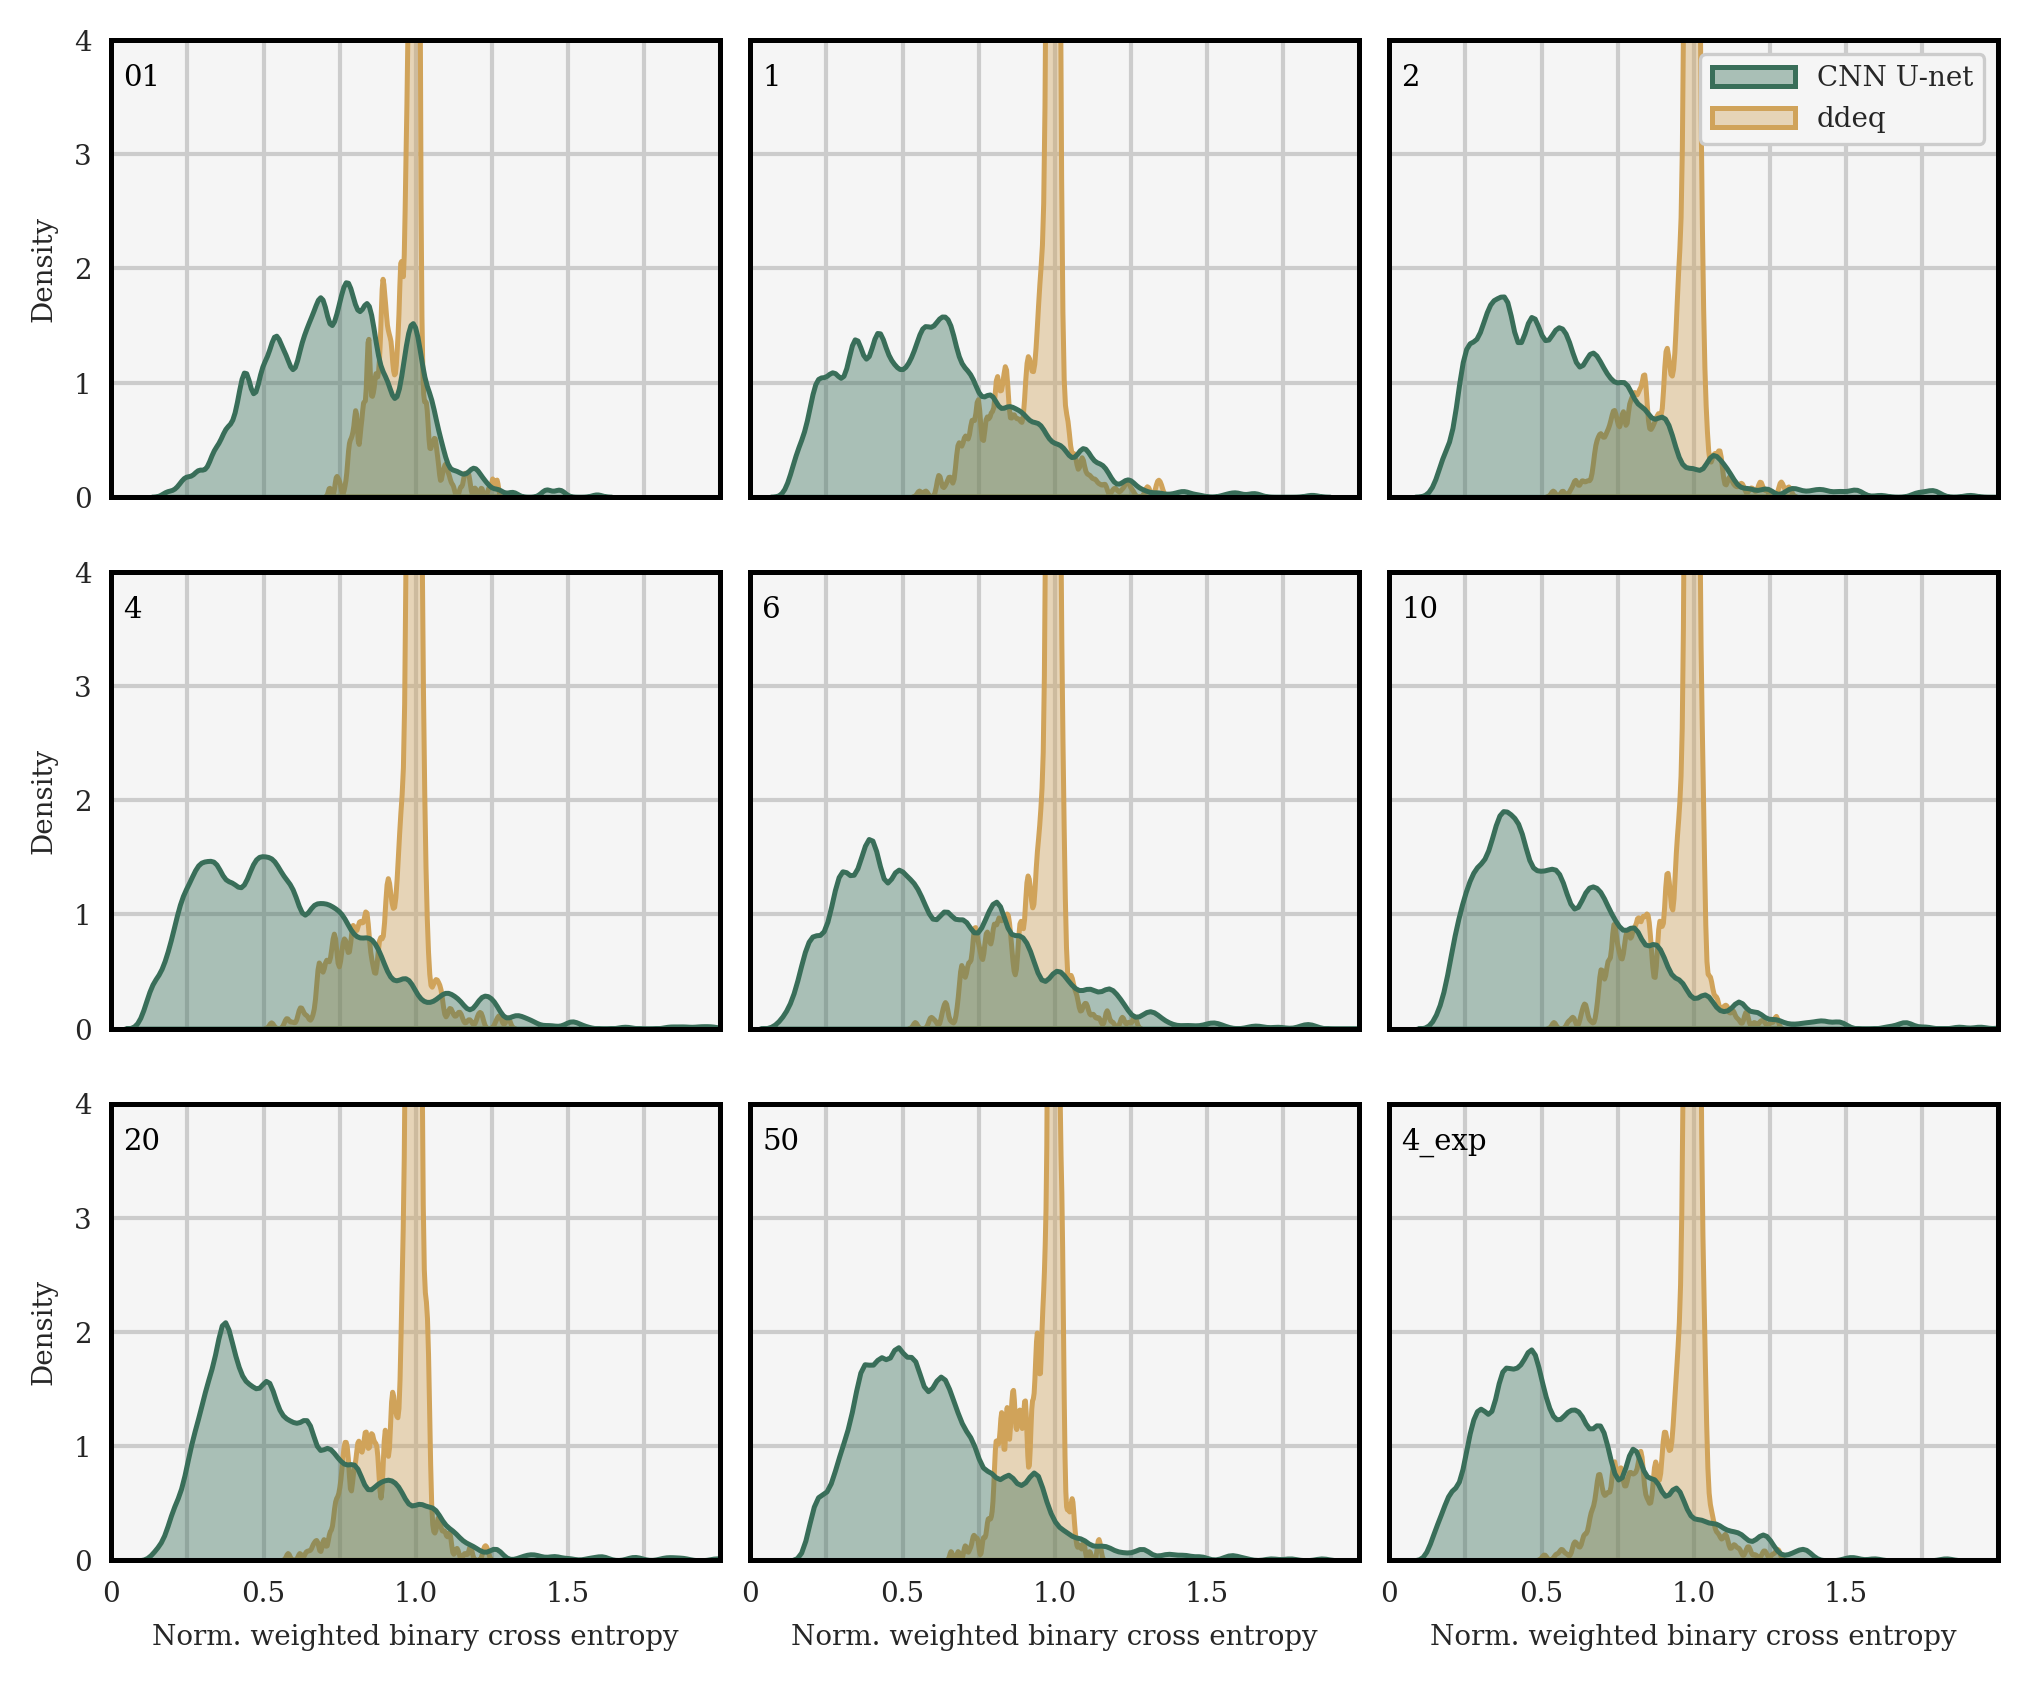

In [47]:
matplotlib_functions.setMatplotlibParam()
axs = matplotlib_functions.set_figure_axs(3, 3, wratio=0.35, hratio=0.75, 
                                          pad_w_ext_left=0.30, pad_w_ext_right=0.30, 
                                          pad_w_int=0.1, pad_h_ext=0.31, pad_h_int=0.25)

dfs = [df_ber_01, df_ber_1, df_ber_2, df_ber_4, df_ber_6, df_ber_10, df_ber_20, df_ber_50, df_ber_4_exp]
titles = ["01", "1", "2", "4", "6", "10", "20", "50", "4_exp"]

for i_ax in range(len(dfs)):
    sns.kdeplot(
        data=dfs[i_ax],
        x="loss",
        hue="method",
        common_norm=False,
        fill=True,
        lw=1.2,
        alpha=0.4,
        levels=1,
        bw_adjust = 0.3, 
        ax = axs[i_ax],
        palette="cmc.batlowW", # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
    )
    axs[i_ax].grid(linewidth=1., alpha=1)
    axs[i_ax].set_xlim(0,2)
    axs[i_ax].set_ylim(0,4)
    axs[i_ax].legend_.set_title(None)

for i_ax in np.delete(np.arange(len(dfs)),[len(dfs)-1, len(dfs)-2, len(dfs)-3]):
    axs[i_ax].set_xticklabels([])
    axs[i_ax].set_xlabel("")
for i_ax in np.delete(np.arange(len(dfs)),[0,3,6]):
    axs[i_ax].set_yticklabels([])
    axs[i_ax].set_ylabel("")
for i_ax in np.delete(np.arange(len(dfs)),2):
    axs[i_ax].get_legend().remove()
for ax in axs:
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
axs[-3].set_xticklabels([0, "", 0.5, "", 1.0, "", 1.5, "", ""])
axs[-2].set_xticklabels([0, "", 0.5, "", 1.0, "", 1.5, "", ""])
axs[-1].set_xticklabels([0, "", 0.5, "", 1.0, "", 1.5, "", ""])
for ax in axs:
    ax.set_yticks([0, 1, 2, 3, 4])
axs[-3].set_xlabel("Norm. weighted binary cross entropy")
axs[-2].set_xlabel("Norm. weighted binary cross entropy")
axs[-1].set_xlabel("Norm. weighted binary cross entropy")

for i, title in enumerate(titles):
    axs[i].annotate(
        title, fontsize=7, xycoords="axes fraction",
        xy=(0.02, 0.9), color="black", fontname="Serif")    

In [39]:
df_ber_CNN_05 = pd.DataFrame({'loss': all_cnn_nwbce_05,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_05) })

NameError: name 'all_cnn_nwbce_05' is not defined

In [45]:
name_w = "2022-12-12_17-23-55"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 96, 96, 1)


nwbce: 0.6544349
idx 76
origin: smart_2km_pBer_nBBer
time: 2015-01-20T04:00:00.000000000
emiss: [14.26594 12.07426 11.74756 11.82039 12.23733 13.52238]
nwbce: 0.22389829
idx 586
origin: smart_2km_pBer_nBBer
time: 2015-07-04T10:00:00.000000000
emiss: [12.01292 11.97695 12.18818 12.53544 13.087   12.28667]
nwbce: 0.6020031
idx 680
origin: smart_2km_pBer_nBBer
time: 2015-08-04T08:00:00.000000000
emiss: [14.18506  14.17169  14.43132  13.47072   9.74944   6.895337]


<Figure size 1920x1440 with 0 Axes>

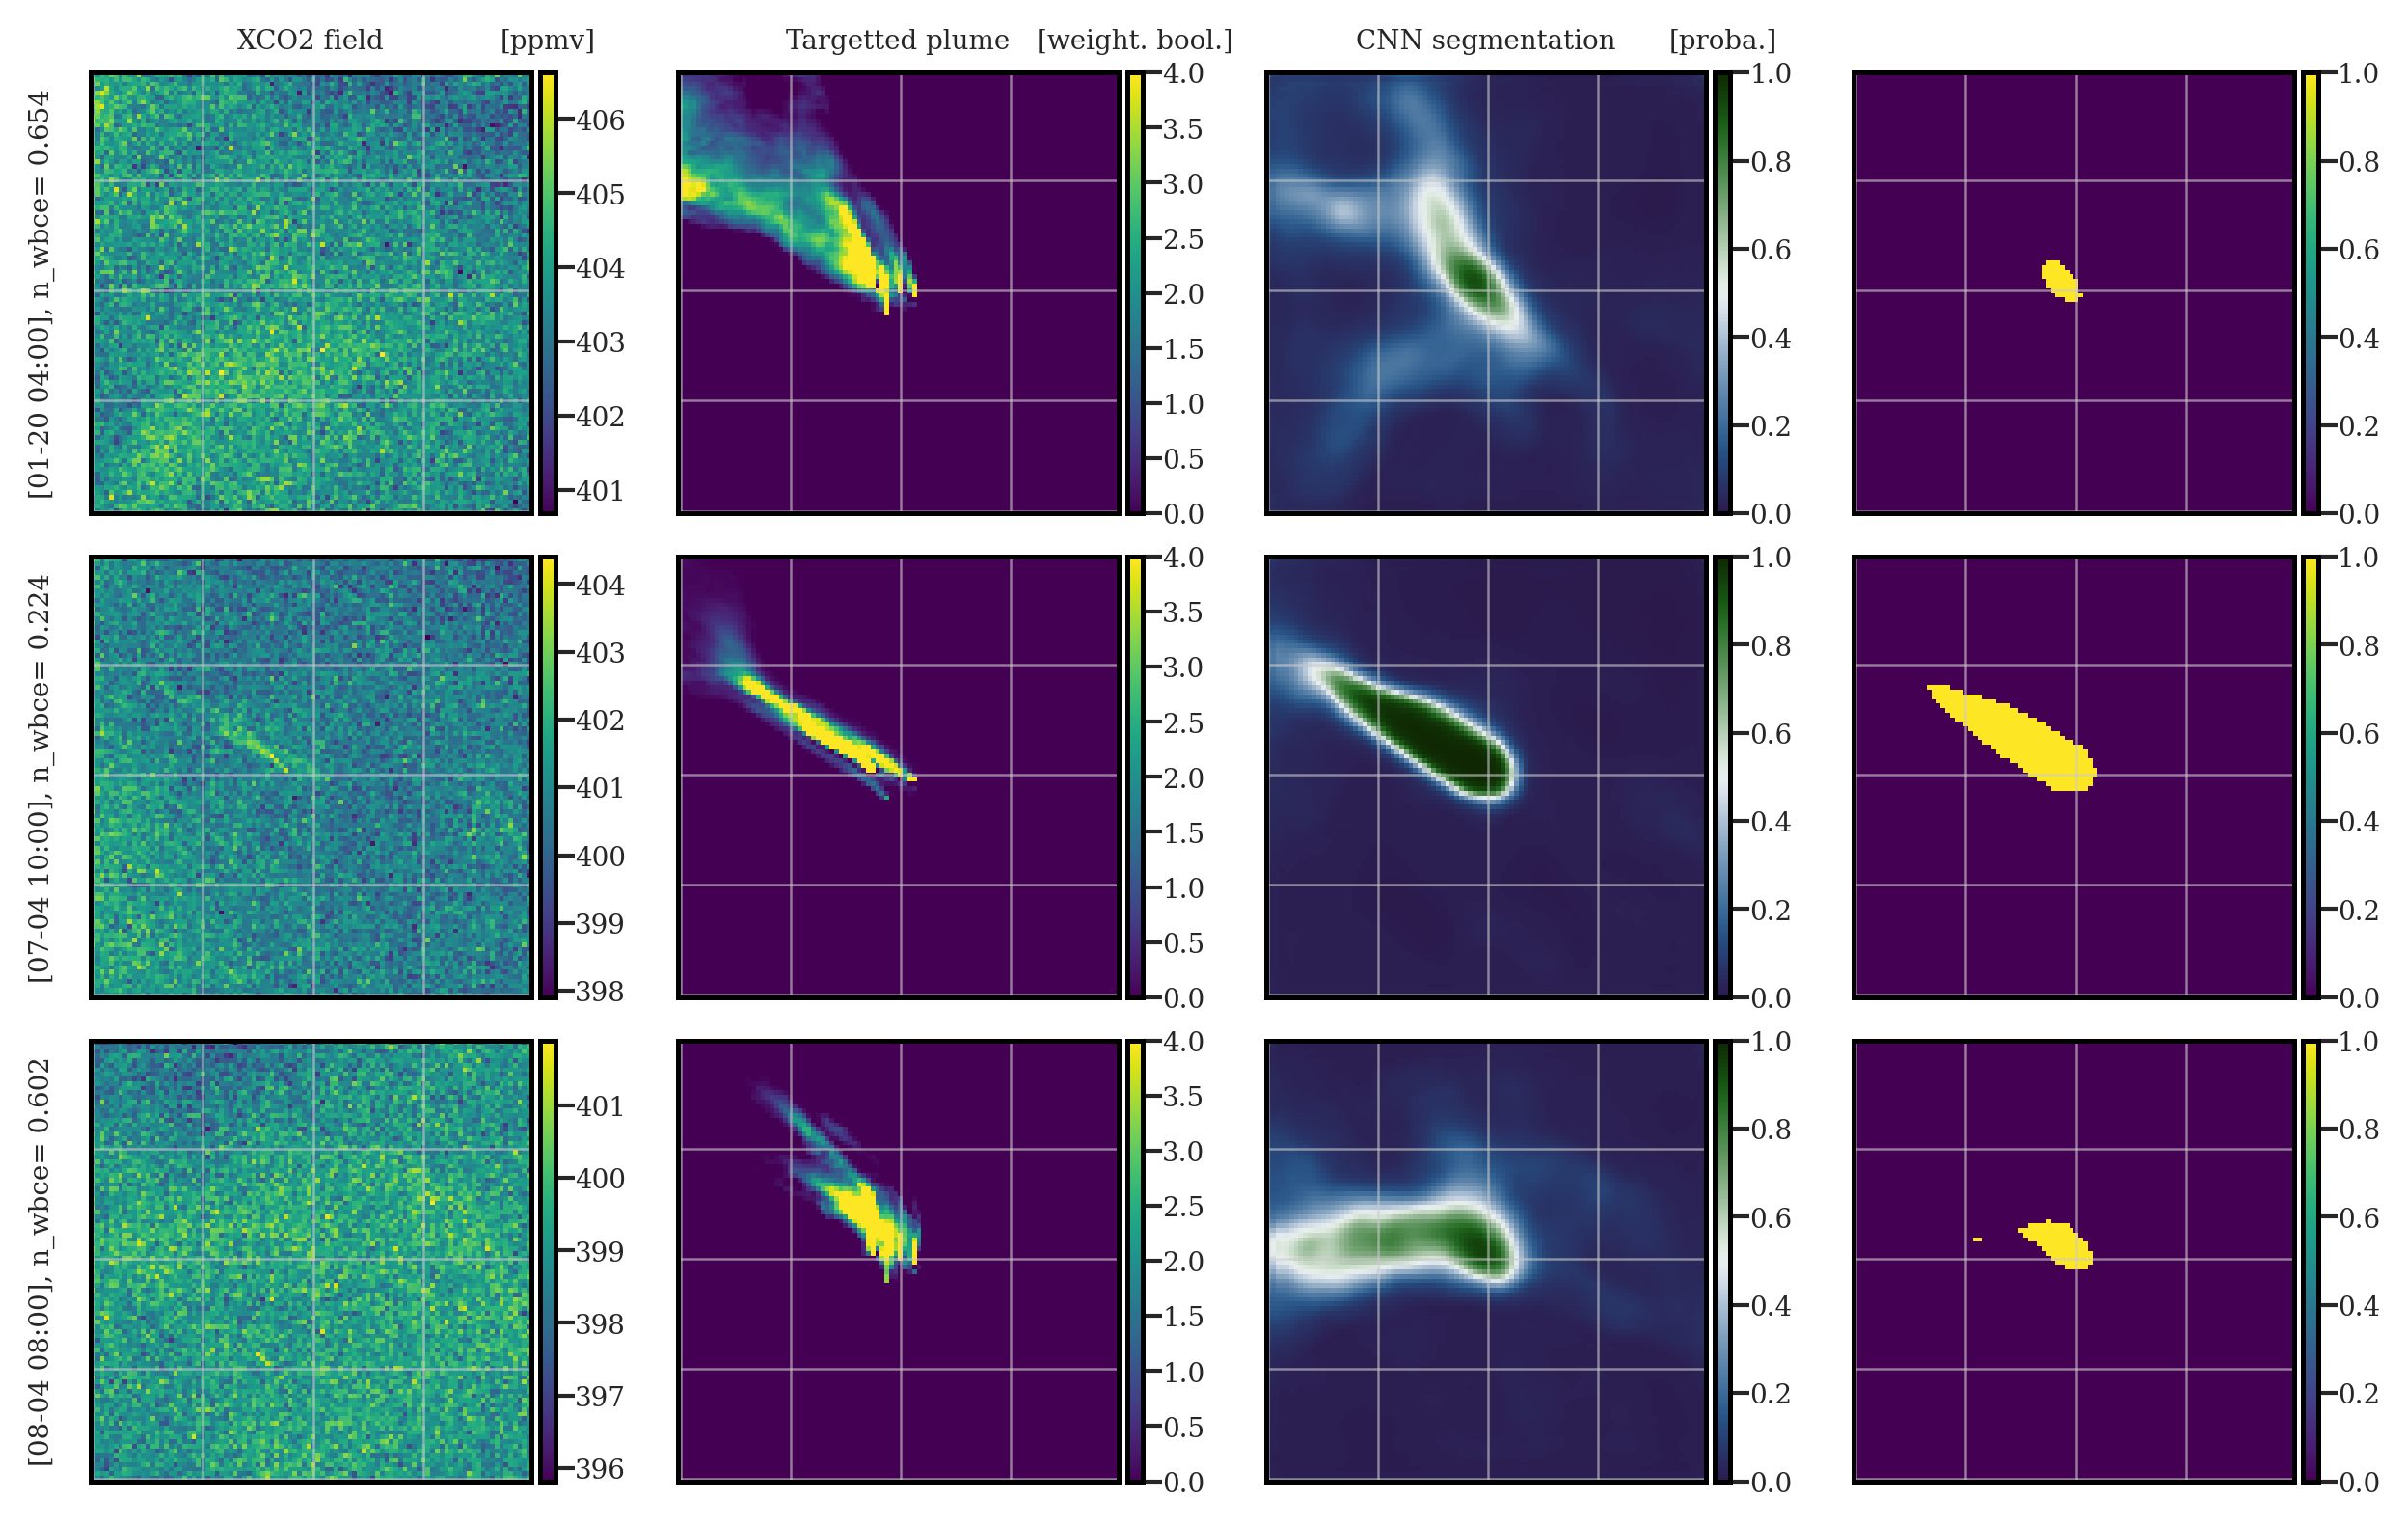

In [56]:
model_eval.plot_segmentation_examples(
    data,
    all_cnn_nwbce,
    model,
    proba_plume = 0.8
)